# Message Classifier, Multi Class, Single Label
Gilbert François Duivesteijn (gilbert@deep-impact.ch)


<img src="https://github.com/gilbertfrancois/pydata2018-tagging/blob/master/images/dt010612.gif?raw=true" width=800>

In [0]:
import os
import pickle as pkl
import re
import string

import matplotlib.pyplot as plt
import nltk
from nltk import tokenize
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn import neighbors
import matplotlib.patches as mpatches

In [0]:
# Import custom library from my github

import urllib.request

def download(url):
    filename = url.split('/')[-1]
    print ('Downloading', filename)
    f =  urllib.request.urlopen(url)
    data = f.read()
    f.close()
    with open(filename, 'wb') as myfile:
        myfile.write(data)

# get .py file from repository
download('https://raw.githubusercontent.com/learning-stack/Colab-ML-Playbook/master/NLP/Automatic%20tagging%20of%20short%20texts/lib/utils.py')

# verify the file if necessary
# print(open('future_encoders.py').read())

In [0]:
from utils import plot_confusion_matrix

In [0]:
np.set_printoptions(precision=3, linewidth=100)
%matplotlib notebook
%matplotlib inline

In [0]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Library functions

In [0]:
stemmer = nltk.PorterStemmer()
analyzer = CountVectorizer().build_analyzer()


def stemmed(doc):
    return [stemmer.stem(w) for w in analyzer(doc)]


def no_stemmed(doc):
    return [w for w in analyzer(doc)]


def mask_integers(s):
    return re.sub(r'\d+', '_INT', s)


def mask_times(text):
    """
    Replaces times written like 12:50, 1PM, 4:15am, etc to _time token.
    :param    text    Input text
    :return           Output text with replaced times.
    """
    re_time1 = '\d{1,2}[:.]\d{2}(?:am|pm|AM|PM)'
    re_time2 = '\d{1,2}[:.]\d{2}'
    re_time3 = '\d{1,2}(?:am|pm|AM|PM)'
    rec_time = re.compile(re_time1 + '|' + re_time2 + '|' + re_time3)
    return re.sub(rec_time, '_TIME', text)


def mask_emojis(text):
    """
    Replaces all different emojis to _emoji token.
    :param    text    Input text
    :return           Output text with replaced emojis.    
    """
    re_icons = ':[a-z-_]*:'
    re_ldsd = '\<(.*?)\>'
    rec_icons = re.compile(re_icons + "|" + re_ldsd)
    return re.sub(rec_icons, '_EMOJI', text)


def mask_all(text):
    text = mask_times(text)
    text = mask_emojis(text)
    text = mask_integers(text)
    return text


def train_and_test(steps, X_train, X_test, y_train, y_test):
    """
    Trains and tests the pipeline with the given steps. 
    :param steps:       List of operations inside the pipeline.
    :param X_train:     Training data
    :param X_test:      Training labels
    :param y_train:     Testing data
    :param y_test:      Testing labels
    :return:            Trained model
    """
    pipeline = Pipeline(steps)
    folds = 10
    xval_score = cross_val_score(pipeline, X_train, y_train, cv=folds, n_jobs=-1)
    
    xv_min = np.min(xval_score)
    xv_max = np.max(xval_score)
    xv_mean = np.mean(xval_score)
    xv_std = np.std(xval_score)
    print('{} fold Cross Validation Score: <{:.2f}, {:.2f}>; µ={:.2f}'.format(folds, xv_min, xv_max, xv_mean))
    pipeline = pipeline.fit(X_train, y_train)
    print('Score on test set: {:.2f}'.format(pipeline.score(X_test, y_test)))
    return pipeline


def tag_message(pipeline, message):
    y_pred = pipeline.predict([message])[0]
    print('{:>20} | {}'.format(dict_classes[y_pred], message))

Challenges:
- Real data, not easy separable in different classes.
- Multi class classification, more difficult than binary classification.
- Small dataset, not a lot of samples to train and test.
- Number of samples are not equally divided over the classes.

| Class | Description                                       |
| ----- | ------------------------------------------------- |
| 1     | Too late, away during office hours or early leave |
| 2     | Holidays or scheduled free days                   |
| 3     | Home Office                                       |
| 4     | Medical appointment                               |
| 5     | Ill, without consulting a medical                 |
| 6     | Work related absence (at client, conference)      |
| 7     | In office announcement                            |
| 8     | Miscellanious                                     |

In [0]:
dict_classes = {
    1: 'late/early',
    2: 'holidays',
    3: 'home office',
    4: 'med app',
    5: 'ill',
    6: 'business',
    7: 'in office',
    8: 'miscellanious'
}

## Vector Space Model (VSM)

### Vectorizer

Before we can use the text messages to train a classifier, we have to transform text into numbers. 

In [0]:
documents = [
    "But I don’t want to go among mad people, Alice remarked.",
    "Oh, you can’t help that, said the Cat: we’re all mad here. I’m mad. You’re mad.",
    "How do you know I’m mad? said Alice.",
    "You must be, said the Cat, or you wouldn’t have come here."
]

vectorizer = CountVectorizer(stop_words='english')
# vectorizer = CountVectorizer(tokenizer=nltk.tokenize.word_tokenize, stop_words='english', strip_accents='unicode')
X = vectorizer.fit_transform(documents)
vectorizer.vocabulary_

{'alice': 0,
 'cat': 1,
 'come': 2,
 'don': 3,
 'help': 4,
 'know': 5,
 'mad': 6,
 'oh': 7,
 'people': 8,
 'remarked': 9,
 'said': 10,
 'want': 11,
 'wouldn': 12}

It creates vector for every document:

In [0]:
X.toarray()

array([[1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0],
       [0, 1, 0, 0, 1, 0, 3, 1, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]], dtype=int64)

When transforming a text with unknown words, like `cat` in this example, vector is empty.

In [0]:
documents2 = ["Cat: Where are you going?",
            "Alice: Which way should I go?"]
X12 = vectorizer.transform(documents2).toarray()
X12

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

### Intermezzo: Search engine 

In [0]:
# Document collection
D = X.toarray()

# query
q = vectorizer.transform(["is alice mad?"]).toarray()

# Do the search by computing the dot product
res = D * q

# Sort highest ranked documents and show only documents with a score > 0
res_ranked = np.sum(res, axis=1)
res_index_sorted = np.argsort(res_ranked)[::-1]
res_index_sorted_filtered = res_index_sorted[res_ranked[res_index_sorted] > 0]

# Print the search results
for index in res_index_sorted_filtered:
    print('[ score: {} ] {}'.format(res_ranked[index], documents[index]))

[ score: 3 ] Oh, you can’t help that, said the Cat: we’re all mad here. I’m mad. You’re mad.
[ score: 2 ] How do you know I’m mad? said Alice.
[ score: 2 ] But I don’t want to go among mad people, Alice remarked.


### Transformer

With a count vectorizer, every word gets counted with the same weight, making frequently occuring words too important. There are several ways to penalizing frequent occuring words and rewarding rare occuring words. The most well known method is called term frequency - inverse document frequency (TF-IDF). TfIdf is implemented in scikit-learn as `TfidfTransformer`. Another algoritm is Okapi-BM25. 

In [0]:
transformer = TfidfTransformer()
Xt = transformer.fit_transform(X)
Xt.toarray()

array([[0.352, 0.   , 0.   , 0.446, 0.   , 0.   , 0.285, 0.   , 0.446, 0.446, 0.   , 0.446, 0.   ],
       [0.   , 0.305, 0.   , 0.   , 0.386, 0.   , 0.74 , 0.386, 0.   , 0.   , 0.247, 0.   , 0.   ],
       [0.505, 0.   , 0.   , 0.   , 0.   , 0.641, 0.409, 0.   , 0.   , 0.   , 0.409, 0.   , 0.   ],
       [0.   , 0.453, 0.575, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.367, 0.   , 0.575]])

### Stopwords

Removing common words from the documents can improve the performance of the classifier. Both NLTK as CountVectorizer provide a lists of stopwords in different languages. Beware that the lists are not the same and might give different results.

In [0]:
for word in sorted(nltk.corpus.stopwords.words('english')):
    print('{}, '.format(word), end='')

a, about, above, after, again, against, ain, all, am, an, and, any, are, aren, aren't, as, at, be, because, been, before, being, below, between, both, but, by, can, couldn, couldn't, d, did, didn, didn't, do, does, doesn, doesn't, doing, don, don't, down, during, each, few, for, from, further, had, hadn, hadn't, has, hasn, hasn't, have, haven, haven't, having, he, her, here, hers, herself, him, himself, his, how, i, if, in, into, is, isn, isn't, it, it's, its, itself, just, ll, m, ma, me, mightn, mightn't, more, most, mustn, mustn't, my, myself, needn, needn't, no, nor, not, now, o, of, off, on, once, only, or, other, our, ours, ourselves, out, over, own, re, s, same, shan, shan't, she, she's, should, should've, shouldn, shouldn't, so, some, such, t, than, that, that'll, the, their, theirs, them, themselves, then, there, these, they, this, those, through, to, too, under, until, up, ve, very, was, wasn, wasn't, we, were, weren, weren't, what, when, where, which, while, who, whom, why, w

In [0]:
for word in sorted(vectorizer.get_stop_words()):
    print('{}, '.format(word), end='')

a, about, above, across, after, afterwards, again, against, all, almost, alone, along, already, also, although, always, am, among, amongst, amoungst, amount, an, and, another, any, anyhow, anyone, anything, anyway, anywhere, are, around, as, at, back, be, became, because, become, becomes, becoming, been, before, beforehand, behind, being, below, beside, besides, between, beyond, bill, both, bottom, but, by, call, can, cannot, cant, co, con, could, couldnt, cry, de, describe, detail, do, done, down, due, during, each, eg, eight, either, eleven, else, elsewhere, empty, enough, etc, even, ever, every, everyone, everything, everywhere, except, few, fifteen, fifty, fill, find, fire, first, five, for, former, formerly, forty, found, four, from, front, full, further, get, give, go, had, has, hasnt, have, he, hence, her, here, hereafter, hereby, herein, hereupon, hers, herself, him, himself, his, how, however, hundred, i, ie, if, in, inc, indeed, interest, into, is, it, its, itself, keep, last

### Stemming

Stemming truncates variations of words into a same shape which helps the classifier to recognise these words as the same token.

In [0]:
doc11 = 'computer computers computing computed'
print(no_stemmed(doc11))
print(stemmed(doc11))

['computer', 'computers', 'computing', 'computed']
['comput', 'comput', 'comput', 'comput']


## Load and prepare the data

In [0]:
!wget https://github.com/gilbertfrancois/pydata2018-tagging/blob/master/data/messages-cls-mc.pkl?raw=true

--2019-01-05 12:24:06--  https://github.com/gilbertfrancois/pydata2018-tagging/blob/master/data/messages-cls-mc.pkl?raw=true
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/gilbertfrancois/pydata2018-tagging/raw/master/data/messages-cls-mc.pkl [following]
--2019-01-05 12:24:06--  https://github.com/gilbertfrancois/pydata2018-tagging/raw/master/data/messages-cls-mc.pkl
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gilbertfrancois/pydata2018-tagging/master/data/messages-cls-mc.pkl [following]
--2019-01-05 12:24:06--  https://raw.githubusercontent.com/gilbertfrancois/pydata2018-tagging/master/data/messages-cls-mc.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.13

In [0]:
df_cls_messages = pd.read_pickle('messages-cls-mc.pkl?raw=true')
df_cls_messages.head(10)

,ts,user,text,class,key,multiclass
0,1.503303e+09,Balaemar,I have to pick up my car from the garage tomor...,1,1503303350U035FRUCY,"[1, 8]"
1,1.503302e+09,Ragaenys,"I won’t be here tomorrow, one day vacation",2,1503301710U4A2FRAQ4,[2]
2,1.503296e+09,Myke,Missed connection in Zurich. Will be about 5-1...,1,1503296123U0MGNKETU,[1]
3,1.503260e+09,Drevyn,Enjoy!,8,1503259722U035B8PRU,[8]
4,1.503258e+09,Gaelralis,I am away for 2 weeks in iceland :flag-is:,2,1503258060U0HLAK1T6,[2]
5,1.503223e+09,Gonaleos,Monday is the first day in school for my son a...,1,1503222795U3W886EF4,"[1, 8]"
6,1.503063e+09,Vaerys,Going to leave around 4:50 because I need to g...,1,1503063218U0PLNK7EK,"[1, 3]"
7,1.503059e+09,Taengaeron,"I am away between 3-4 for private stuff, be ba...",1,1503059074U4C55CKGX,"[1, 3]"
8,1.503058e+09,Baegar,I will move to HO. I will be in 2 different Te...,3,1503057526U035J4RG4,"[3, 6, 8]"
9,1.503057e+09,Eliar,Need to leave around 16:45. Will be available ...,1,1503056595U0A8NPHRD,"[1, 3]"


In [0]:
# Remove all rows which have no annotation
samples = df_cls_messages.dropna()

# Convert the classification column to unsigned int, in case it is stored as string
samples['class'] = samples.loc[:, 'class'].astype(np.uint8).values

X = samples['text']
y = samples['class']

print('[.] Number of training samples: {}'.format(len(X)))

[.] Number of training samples: 1719


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

## Building a pipeline and training the first model

Scikit Learn offers a great way to combine the preprocessing (vectorization, stemming, stopword removal, etc) and training/predicting by building a pipeline. Let's see how that works...

More information on pipelines, look at this nice blog post:

https://buhrmann.github.io/sklearn-pipelines.html

In [0]:
steps = [('vectorizer', CountVectorizer()),
         ('classifier', LinearSVC(random_state=1))]
pipeline1 = train_and_test(steps, X_train, X_test, y_train, y_test)

10 fold Cross Validation Score: <0.75, 0.85>; µ=0.81
Score on test set: 0.82


Normalized confusion matrix


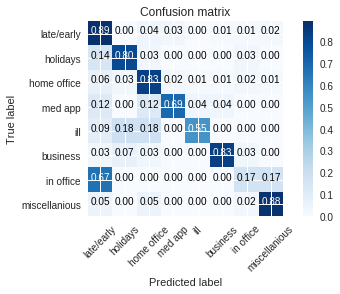

In [0]:
y_pred = pipeline1.predict(X_test)
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
plt.figure()
plot_confusion_matrix(cm, classes=dict_classes.values(), normalize=True);

Let's see what parameters are available and have been set by default:

In [0]:
pipeline1.get_params()

{'classifier': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
      verbose=0),
 'classifier__C': 1.0,
 'classifier__class_weight': None,
 'classifier__dual': True,
 'classifier__fit_intercept': True,
 'classifier__intercept_scaling': 1,
 'classifier__loss': 'squared_hinge',
 'classifier__max_iter': 1000,
 'classifier__multi_class': 'ovr',
 'classifier__penalty': 'l2',
 'classifier__random_state': 1,
 'classifier__tol': 0.0001,
 'classifier__verbose': 0,
 'memory': None,
 'steps': [('vectorizer',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=1.0, max_features=None, min_df=1,
           ngram_range=(1, 1), preprocessor=None, stop_words=None,
           strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b'

All objects in the pipeline are stored in a dictonary. You can easily access them like any ordinary python dictionary. E.g. you want to transform only a document to a vector. This can be useful if you want to have the output of the preprocessing step for plotting or further analysis. 

In [0]:
vectorizer = pipeline1.get_params()['vectorizer']
vectorizer.transform(['A new document']).toarray()

array([[0, 0, 0, ..., 0, 0, 0]])

Let's add a TF-IDF transformer that suppress the weight of common words and make special words more important.

In [0]:
steps = [('vectorizer', CountVectorizer()),
         ('tfidf', TfidfTransformer()),
         ('classifier', LinearSVC(random_state=1))]
pipeline2 = train_and_test(steps, X_train, X_test, y_train, y_test)

10 fold Cross Validation Score: <0.80, 0.87>; µ=0.83
Score on test set: 0.84


In [0]:
steps = [('vectorizer', CountVectorizer(analyzer=stemmed)),
         ('tfidf', TfidfTransformer()),
         ('classifier', LinearSVC(random_state=1))]
pipeline3 = train_and_test(steps, X_train, X_test, y_train, y_test)

10 fold Cross Validation Score: <0.80, 0.88>; µ=0.84
Score on test set: 0.85


In [0]:
steps = [('vectorizer', CountVectorizer(analyzer=stemmed, 
                                        stop_words='english')),
        ('tfidf', TfidfTransformer()),
        ('classifier', LinearSVC(random_state=1))]
pipeline4 = train_and_test(steps, X_train, X_test, y_train, y_test)

10 fold Cross Validation Score: <0.80, 0.88>; µ=0.84
Score on test set: 0.85


In [0]:
steps = [('vectorizer', CountVectorizer(ngram_range=(1, 2))),
         ('tfidf', TfidfTransformer()),
         ('classifier', LinearSVC(random_state=1))]
pipeline5 = train_and_test(steps, X_train, X_test, y_train, y_test)

10 fold Cross Validation Score: <0.79, 0.86>; µ=0.83
Score on test set: 0.85


In [0]:
steps = [('vectorizer', CountVectorizer(ngram_range=(1, 3))),
         ('tfidf', TfidfTransformer()),
         ('classifier', LinearSVC(random_state=1))]
pipeline6 = train_and_test(steps, X_train, X_test, y_train, y_test)

10 fold Cross Validation Score: <0.80, 0.85>; µ=0.83
Score on test set: 0.86


In [0]:
steps = [('vectorizer', CountVectorizer(preprocessor=mask_all, 
                                        analyzer=stemmed, 
                                        stop_words='english', 
                                        ngram_range=(1, 3))),
         ('tfidf', TfidfTransformer()),
         ('classifier', LinearSVC(random_state=1))]
pipeline7 = train_and_test(steps, X_train, X_test, y_train, y_test)

10 fold Cross Validation Score: <0.80, 0.88>; µ=0.84
Score on test set: 0.85


## One vs Rest Classifiers

Let's train 8 classifiers: One vs Rest

In [0]:
enc = OneHotEncoder()
ym_train = enc.fit_transform(np.array(y_train.tolist()).reshape(-1,1))
ym_test = enc.transform(np.array(y_test.tolist()).reshape(-1,1))

steps = [('vectorizer', CountVectorizer(analyzer=stemmed, 
                                        stop_words='english', 
                                        preprocessor=mask_all)),
         ('transformer', TfidfTransformer()),
         ('classifier', OneVsRestClassifier(LinearSVC(random_state=1, multi_class='ovr')))]
pipeline8 = train_and_test(steps, X_train, X_test, ym_train, ym_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


10 fold Cross Validation Score: <0.67, 0.78>; µ=0.73
Score on test set: 0.74


In [0]:
steps = [('vectorizer', CountVectorizer(ngram_range=(1,3), 
                                        analyzer=stemmed, 
                                        stop_words='english', 
                                        preprocessor=mask_all)),
         ('transformer', TfidfTransformer()),
         ('classifier', OneVsOneClassifier(LinearSVC(random_state=1, multi_class='ovr')))]
pipeline9 = train_and_test(steps, X_train, X_test, y_train, y_test)

10 fold Cross Validation Score: <0.80, 0.87>; µ=0.83
Score on test set: 0.82


In [0]:
y_pred = pipeline9.predict(X_test)

print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           1       0.76      0.91      0.83       100
           2       0.80      0.80      0.80        35
           3       0.87      0.82      0.84        95
           4       0.89      0.65      0.76        26
           5       0.71      0.45      0.56        11
           6       0.92      0.77      0.84        30
           7       0.50      0.33      0.40         6
           8       0.89      0.95      0.92        41

   micro avg       0.82      0.82      0.82       344
   macro avg       0.79      0.71      0.74       344
weighted avg       0.83      0.82      0.82       344



Normalized confusion matrix


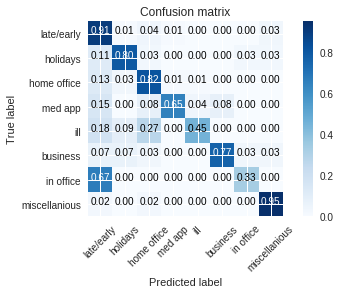

In [0]:
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
plt.figure()
plot_confusion_matrix(cm, classes=dict_classes.values(), normalize=True);

In [0]:
%%time

steps = [('vectorizer', CountVectorizer()),
         ('transformer', TfidfTransformer()),
         ('classifier', SVC(kernel='linear', random_state=1))]
pipeline10 = Pipeline(steps)

params = {
    'vectorizer__tokenizer': [None, nltk.tokenize.word_tokenize],
    'vectorizer__analyzer': ['word', stemmed],
    'vectorizer__stop_words': [None, nltk.corpus.stopwords.words('english'), 'english'],
    'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3)],
    'vectorizer__preprocessor': [None, mask_all, mask_integers, mask_times, mask_emojis],
    'classifier__C': np.logspace(-2, 2, 5),
    'classifier__gamma': np.logspace(-5, 3, 9)
}

gs = GridSearchCV(pipeline10, params, n_jobs=-1)
gs.fit(X_train, y_train)

print(gs.best_params_)
y_pred = gs.predict(X_test)
print(classification_report(y_pred=y_pred, y_true=y_test))
print('Score on the test set: {:.2f}'.format(gs.score(X_test, y_test)))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'classifier__C': 1.0, 'classifier__gamma': 1e-05, 'vectorizer__analyzer': <function stemmed at 0x7f8b69ebed08>, 'vectorizer__ngram_range': (1, 1), 'vectorizer__preprocessor': None, 'vectorizer__stop_words': None, 'vectorizer__tokenizer': None}
              precision    recall  f1-score   support

           1       0.76      0.89      0.82       100
           2       0.80      0.80      0.80        35
           3       0.86      0.83      0.84        95
           4       0.89      0.65      0.76        26
           5       0.71      0.45      0.56        11
           6       0.89      0.80      0.84        30
           7       0.67      0.33      0.44         6
           8       0.89      0.95      0.92        41

   micro avg       0.82      0.82      0.82       344
   macro avg       0.81      0.71      0.75       344
weighted avg       0.82      0.82      0.82       344

Score on the test set: 0.82
CPU times: user 4min 24s, sys: 4.92 s, total: 4min 29s
Wall time: 5h 37min 2

You can try a gridsearch with another classifier. But it is hard to beat Linear SVM.

In [0]:
#%%time
#
#steps = [('vectorizer', CountVectorizer()),
#         ('transformer', TfidfTransformer()),
#         ('classifier', RandomForestClassifier())]
#pipeline11 = Pipeline(steps)

#params = {
#    'vectorizer__tokenizer': [None, nltk.tokenize.word_tokenize],
#    'vectorizer__analyzer': ['word', stemmed],
#    'vectorizer__stop_words': [None, nltk.corpus.stopwords.words('english'), 'english'],
#    'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3)],
#    'vectorizer__preprocessor': [None, mask_all, mask_integers, mask_times, mask_emojis],
#    'classifier__n_estimators': [128, 512, 2048],
#    'classifier__bootstrap': [True, False],
#    'classifier__criterion': ['gini', 'entropy'], 
#    'classifier__max_depth': [2, 4, 8, None],
#    'classifier__min_samples_leaf': [1, 3, 10], 
#    'classifier__min_samples_split': [2, 8, 16]
#}

#gs = GridSearchCV(pipeline11, params, n_jobs=-1)
#gs.fit(X_train, y_train)

#print(gs.best_params_)
#y_pred = gs.predict(X_test)
#print(classification_report(y_pred=y_pred, y_true=y_test))
#print('Score on the test set: {:.2f}'.format(gs.score(X_test, y_test)))

In [0]:
pipeline = gs

tag_message(pipeline, 'My alarm clock was not set properly. I come to the office asap.')
tag_message(pipeline, 'It is my scheduled day off, see you on Tuesday.')
tag_message(pipeline, 'Not feeling well today, I stay home and work from here.')
tag_message(pipeline, 'I work at home on Tuesday.')
tag_message(pipeline, 'This morning I have a meeting at SPS.')
tag_message(pipeline, 'I\'m off, see you tomorrow.')
tag_message(pipeline, 'get well soon!')
tag_message(pipeline, 'I\'m away for a long lunch between 12:00 and 15:30')
tag_message(pipeline, 'I\'ve an appointment at 12:00 at the physiotherapy.')

          late/early | My alarm clock was not set properly. I come to the office asap.
            holidays | It is my scheduled day off, see you on Tuesday.
                 ill | Not feeling well today, I stay home and work from here.
         home office | I work at home on Tuesday.
            business | This morning I have a meeting at SPS.
            holidays | I'm off, see you tomorrow.
       miscellanious | get well soon!
          late/early | I'm away for a long lunch between 12:00 and 15:30
             med app | I've an appointment at 12:00 at the physiotherapy.
